In [1]:
import json, cv2, numpy as np, itertools, random, pandas as pd
from pycocotools.coco import COCO
from pycocotools import mask as maskUtils
from skimage import io
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.auto import tqdm
from sklearn import model_selection
from copy import deepcopy

In [2]:
df = pd.read_csv("/notebooks/data/input/tile_meta.csv")
df.head()

,id,source_wsi,dataset,i,j
0,0006ff2aa7cd,2,2,16896,16420
1,000e79e206b7,6,3,10240,29184
2,00168d1b7522,2,2,14848,14884
3,00176a88fdb0,7,3,14848,25088
4,0033bbc76b6b,1,1,10240,43008


In [3]:
#df = df[df["dataset"]==3]
df = df[df["dataset"]!=1]

In [4]:
def binary_mask_to_rle(binary_mask):
    rle = {'counts': [], 'size': list(binary_mask.shape)}
    counts = rle.get('counts')
    for i, (value, elements) in enumerate(itertools.groupby(binary_mask.ravel(order='F'))):
        if i == 0 and value == 1:
            counts.append(0)
        counts.append(len(list(elements)))
    return rle

In [5]:
jsonl_file_path = "/notebooks/data/input/polygons.jsonl"
data = []
with open(jsonl_file_path, "r") as file:
    for line in file:
        data.append(json.loads(line))

coco_data = {"info": {}, "licenses": [], "categories": [], "images": [], "annotations": []}

categories = []
for item in tqdm(data, dynamic_ncols=True):
    annotations = item["annotations"]
    for annotation in annotations:
        annotation_type = annotation["type"]
        if annotation_type not in categories:
            categories.append(annotation_type)
            coco_data["categories"].append({"id": len(categories), "name": annotation_type})
            
#train_coco_data = deepcopy(coco_data)
#valid_coco_data = deepcopy(coco_data)

  0%|          | 0/1633 [00:00<?, ?it/s]

In [6]:
for image_id in tqdm(df["id"], dynamic_ncols=True):
    
    image_info = {"id": image_id, "file_name": image_id + ".tif", "height": 512, "width": 512}
    coco_data["images"].append(image_info)
    masks = np.load(f"/pseudo/{image_id}_pseudo.npz")["arr_0"]
    
    cat = "blood_vessel"

    for mask in masks:
        
        if np.all(mask == False):
            mask_tmp = mask.copy()
            continue
            
        ys, xs = np.where(mask)
        x1, x2 = min(xs), max(xs)
        y1, y2 = min(ys), max(ys)
            
        category_id = categories.index(cat) + 1

        rle = binary_mask_to_rle(mask)

        annotation_info = {
            "id": len(coco_data["annotations"]) + 1,
            "image_id": image_id,
            "category_id": category_id,
            "segmentation": rle,
            "bbox": [int(x1), int(y1), int(x2 - x1 + 1), int(y2 - y1 + 1)],
            "area": int(np.sum(mask)),
            "iscrowd": 0,
        }
        coco_data["annotations"].append(annotation_info)

  0%|          | 0/6611 [00:00<?, ?it/s]

In [7]:
#output_file_path = "coco_annotations_train_all.json"
#with open(output_file_path, "w", encoding="utf-8") as output_file:
#    json.dump(train_coco_data, output_file, ensure_ascii=True, indent=4)
    
#output_file_path = "coco_annotations_valid_all.json"
#with open(output_file_path, "w", encoding="utf-8") as output_file:
#    json.dump(valid_coco_data, output_file, ensure_ascii=True, indent=4)

output_file_path = "/notebooks/data/input/coco_annotations_pseudo2_c095_convnext_train_all.json"
with open(output_file_path, "w", encoding="utf-8") as output_file:
    json.dump(coco_data, output_file, ensure_ascii=True, indent=4)

loading annotations into memory...
Done (t=0.74s)
creating index...
index created!
6611


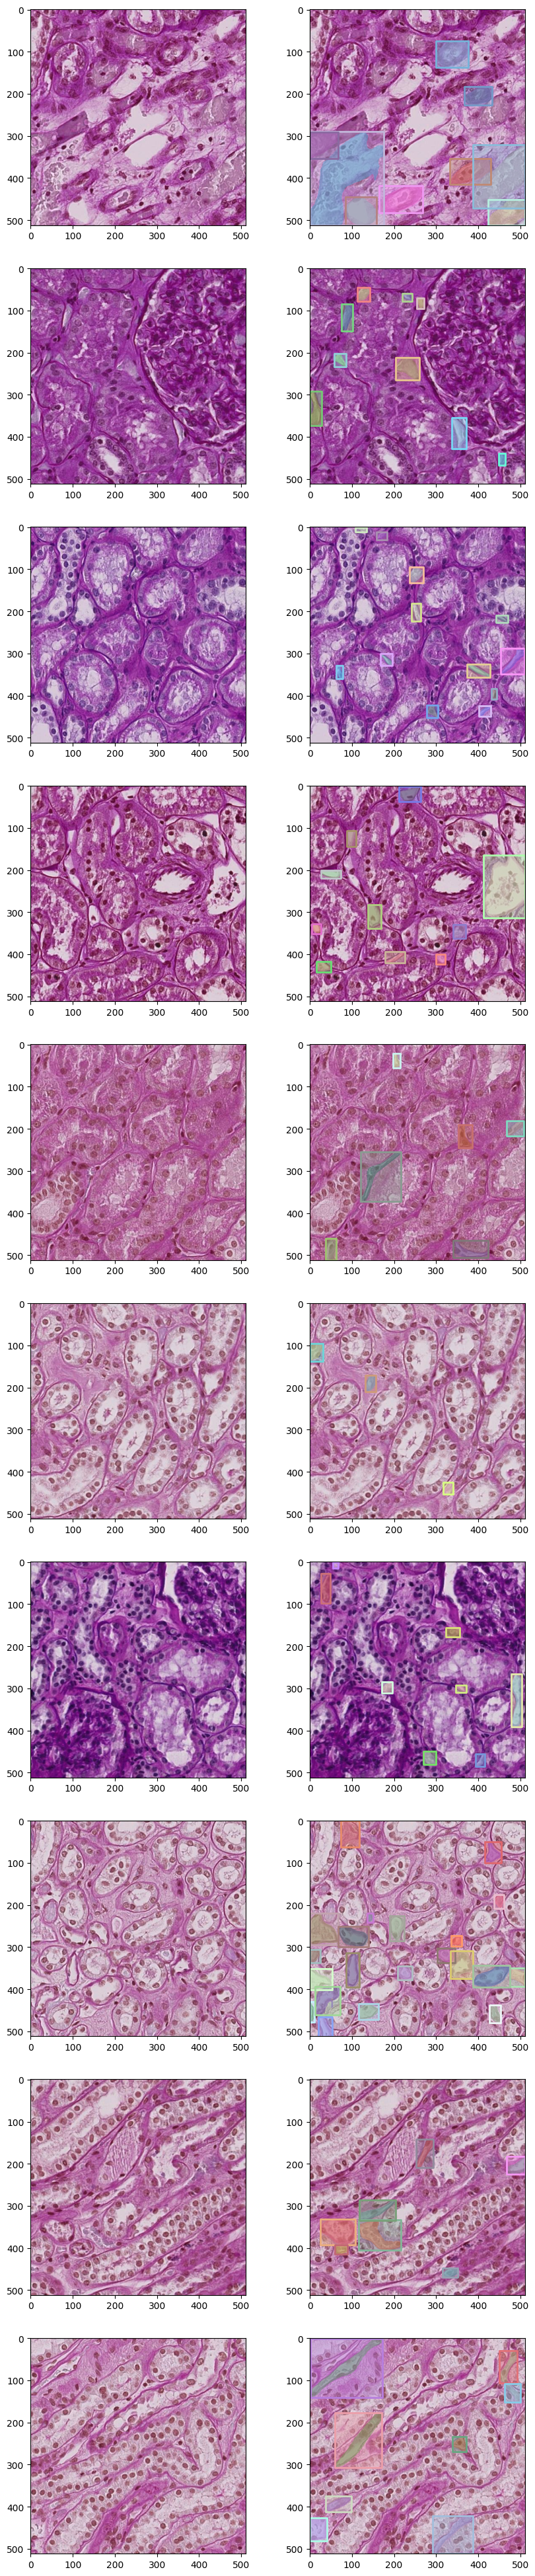

In [8]:
dataDir = Path("/notebooks/data/input/train")
annFile = Path("/notebooks/data/input/coco_annotations_pseudo2_c095_convnext_train_all.json")
coco = COCO(annFile)

imgIds = coco.getImgIds()
print(len(imgIds))
imgs = coco.loadImgs(random.sample(imgIds, 10))

imgs = coco.loadImgs(imgIds[-10:])
fig, axs = plt.subplots(len(imgs), 2, figsize=(10, 5*len(imgs)))

for img, ax_row in zip(imgs, axs):
    ax = ax_row[0]  # Access the first axis in each row
    I = io.imread(dataDir / img["file_name"])
    annIds = coco.getAnnIds(imgIds=[img["id"]])
    anns = coco.loadAnns(annIds)
    ax.imshow(I)

    ax = ax_row[1]  # Access the second axis in each row
    ax.imshow(I)
    plt.sca(ax)
    coco.showAnns(anns, draw_bbox=True)